## Imports

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns
import sys
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

import multiprocessing
sys.path.append('../src')
from utils import load_dataset, plot_spectrum, load_retention_times

# Data preparation
* Variance thresholding
* Normalization so that the mean is 0 and variance is 1

### Load data and split them into features X and target y

In [2]:
data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 9.2 seconds.
[INFO] Input data shapes: X[(23430, 801)], y[(23430,)]


In [4]:
data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', use_retention_time=True, verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 7.4 seconds.
[INFO] Input data shapes: X[(23430, 803)], y[(23430,)]


## Normalize data

In [26]:
metadata

,system,annotator_ID,measurement_number,compound
0,1,M10,07,Octocrylene
1,1,F13,06,"9-Hexadecenoic acid, dodecyl ester"
2,1,F14,02,Triethylene glycol monododecyl ether
3,1,F3,04,"Methoxyacetic acid, tetradecyl ester"
4,2,F15,12,"2,5-pyrrolidinedione, 3-dodecyl-"
...,...,...,...,...
23425,3,F15,16,Cholesterol
23426,1,F15,06,"2,5-pyrrolidinedione, 3-hexadecyl-"
23427,1,M3,01,"2-Propenoic acid, 3-(4-methoxyphenyl)-, 2-ethy..."
23428,3,F14,15,"Cholesta-3,5-dien-7-one"


In [45]:
X.mean(0)[28:35]

array([0.24047124, 0.02868588, 0.10500107, 0.58941233, 0.00366926,
       0.00363432], dtype=float32)

In [50]:
X[0, :29].size

29

In [56]:
metadata['compound'].value_counts()

Hexadecanoic acid, tetradecyl ester                                        349
9-Hexadecenoic acid, octadecyl ester                                       349
2,5-pyrrolidinedione, 3-dodecyl-                                           349
Squalene                                                                   349
Hexadecanoic acid, hexadecyl ester                                         349
Hexadecanoic acid, dodecyl ester                                           349
9-Hexadecenoic acid, tetradecyl ester                                      349
9-Hexadecenoic acid, hexadecyl ester                                       349
Cholesterol                                                                349
2,5-pyrrolidinedione, 3-tetradecyl-                                        349
Heptacosane                                                                349
Tetradecane, 1-chloro-                                                     349
2,5-pyrrolidinedione, 3-decyl-                      

In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
metadata.groupby(['compound'])['measurement_number'].count()

compound
1-Decanol, 2-hexyl-                                                        343
1-Dodecanamine, N,N-dimethyl-                                              334
1-Dodecanol                                                                348
1-Hexadecanamine, N,N-dimethyl-                                            341
1-Hexadecanol                                                              347
1-Octadecanol                                                              347
1-Octanol, 2-hexyl-                                                        348
1-Tetradecanamine, N,N-dimethyl-                                           338
1-Tetradecanol                                                             348
2,5-pyrrolidinedione, 3-decyl-                                             349
2,5-pyrrolidinedione, 3-dodecyl-                                           349
2,5-pyrrolidinedione, 3-hexadecyl-                                         348
2,5-pyrrolidinedione, 3-tetradecyl-        

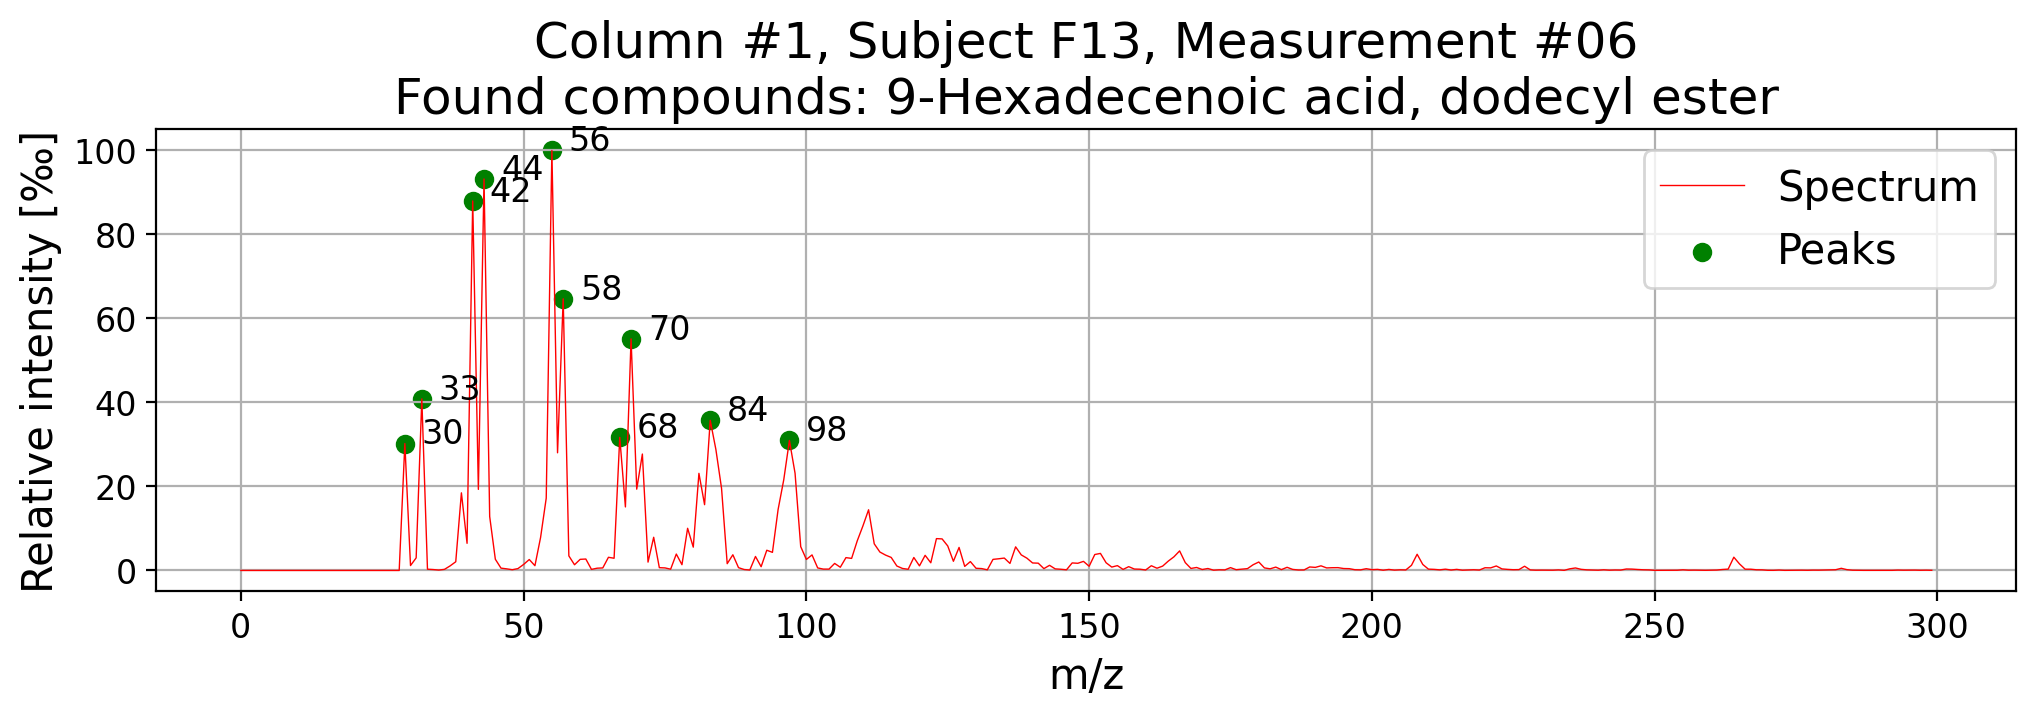

In [18]:
plot_spectrum(X[1, :300], metadata.iloc[1], top_n=10, figsize=(12, 3), dpi=200, save_plot=True)

In [9]:
X.argmax(1)[:100]

array([ 32,  55,  45,  45,  99,  32,  32,  32,  45,  32,  32,  43,  41,
        32,  45,  32,  32,  99,  99,  58,  32,  57,  45,  32,  99,  32,
        84,  45,  32,  45,  32,  43,  45,  32,  41,  32,  32,  45,  32,
        43,  32,  99,  32,  32,  32,  32, 178,  32,  32,  43,  32,  32,
        99,  32,  32,  57,  32,  55,  41,  41,  32,  32,  58,  32,  58,
        32,  32, 123,  32,  32,  32,  43,  57,  32,  57,  32,  43,  99,
        57,  32,  32,  58,  43,  32,  55,  45,  45,  32,  41,  43,  32,
        32,  58,  45,  45,  84,  32,  41,  55,  41])

In [5]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='max')
X = normalizer.fit_transform(X)
X[:, -2:] = normalizer.fit_transform(X[:, -2:])
X[:, -2] /= 3600
X[:, -1] /= 10

# Modeling + Training
**LinearSVC**
Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.



### Add sample weights to adjust for imbalanced classes

In [3]:
%matplotlib inline
from matplotlib.text import Text
from matplotlib.ticker import PercentFormatter

def plot_prediction_hist(classification_predictions, use_logspace=True, use_percentage=False):
    predicted_classes = np.unique(classification_predictions).size
    plt.figure(figsize=(10, 8))
    plt.hist(classification_predictions, 
             edgecolor='black', 
             bins=np.linspace(0, 69, 70),
             weights=np.ones_like(classification_predictions) / len(classification_predictions))
    if use_logspace:
        plt.gca().set_yscale("log")
        ticks = [1e-4, 1e-3, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
        ticks_labels = [Text(0, t, f'{t}') for t in ticks]
        plt.yticks(ticks, ticks_labels)
    plt.xlabel('Predicted classes [0-69]')
    if use_percentage:
        plt.ylabel('Log relative frequencies of predicted classes [%]')
        vals = plt.gca().get_yticks()
        plt.gca().set_yticklabels([f'{i*100:.2f}%' for i in vals])
    else:
        plt.ylabel('Log relative frequencies of predicted classes')
    plt.title(f'Scaled histogram of SVM predictions - total of {predicted_classes} predicted In-Distribution classes')
    
    plt.show()

In [172]:
data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', use_retention_time=True, verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

# Load test dataset and predict labels
data_root_path = "../data"
ood_dataset_name = "M29_9_system2"
gcxgc = np.load(f"{data_root_path}/ood/{ood_dataset_name}/{ood_dataset_name}.npy")

# Calculate normalized retention times
t1 = np.array([6*i for i in range(0, 200+1, 1)] + [6*200 + 8*i for i, _ in enumerate(range(201, 311+1, 1))] + [6*200 + 8*111 + 10*i for i, _ in enumerate(range(312, gcxgc.shape[2], 1))])
t1 = t1.reshape(1, -1)
t2 = np.array([0.005*i for i in range(gcxgc.shape[1])])
t2 = t2.reshape(-1, 1)

gcxgc_normalized = np.sum(gcxgc, axis=0)

# concatenate with the 801-dimensional vector of spectrums
t1_2d = np.tile(t1, (2000, 1))
t2_2d = np.tile(t2, (1, 460))
t1_2d = np.expand_dims(t1_2d, axis=0)
t2_2d = np.expand_dims(t2_2d, axis=0)
gcxgc = np.concatenate((gcxgc, t1_2d, t2_2d), axis=0)

eps = 0
mask_valid_measurements = (gcxgc_normalized > eps)
X_unknown = gcxgc[:, mask_valid_measurements].transpose(1, 0)
print("[INFO] Testing dataset loaded.")

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 7.5 seconds.
[INFO] Input data shapes: X[(23430, 803)], y[(23430,)]
[INFO] Testing dataset loaded.


#### Computation of `M29_9_system2` retention times
retention time *t1*
* prvnich 200 sloupcu t1 = 6 * cislo sloupce
* 201-311 sloupec t1 = 6 * 200 + 8 * cislo_sloupce
* 312 sloupec a dal t1 = 6 * 200 + 8 * 111 + 10 * cislo_sloupce 

retention time *t2*
* t2 se pocita jako:
* t2 = cislo_radku * 0.005

In [173]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='max')
X[:, -2:] = normalizer.fit_transform(X[:, -2:])
X[:, -2] /= 3600
X[:, -1] /= 10

X_unknown[:, -2:] = normalizer.fit_transform(X_unknown[:, -2:])
X_unknown[:, -2] /= 3600
X_unknown[:, -1] /= 10

### Add noise impuls noise to training data 

In [6]:
from copy import deepcopy
import random

def add_noise_to_data_point(data, seed, noise_count, noise_range):
    if noise_count == 'rand':
        noise_count = random.randint(1, 5)
    rng = np.random.default_rng(seed)
    noise_sample = rng.uniform(noise_range[0] * np.min(data), noise_range[1] * np.max(data), noise_count)

    # Generate an array of zeros with a size that is the difference of the sizes of the original data an the noise sample.
    zeros = np.zeros(len(data) - len(noise_sample))
    
    # Add the noise sample to the zeros array to obtain the final noise with the same shape as that of the original data.
    noise = np.concatenate([noise_sample, zeros])
    
    # Shuffle the values in the noise to make sure the values are randomly placed.
    np.random.shuffle(noise)
    
    # Obtain data with the noise added.
    noised = data + noise
    return noised

def add_noise_to_data(data, stratify, normalizer, seed, noise_percentage=0.03, noise_count=1, noise_range=(0.1, 10.0)):
    num_elements = int(noise_percentage * data.shape[0])
    if stratify is None:
        indices = np.random.choice(np.arange(data.shape[0]), num_elements, replace=False)
    else:
        unique_labels, class_counts = np.unique(stratify, return_counts=True)
        samples_per_class = max(1, int(noise_percentage * class_counts.mean()))
        print(f"{samples_per_class} samples per class")
        np.random.seed(seed)
        indices = np.concatenate([
            np.random.choice(np.where(stratify == i)[0], samples_per_class, replace=False)
            for i in range(len(unique_labels))
        ])
    new_data = deepcopy(data)
    new_data[indices] = np.apply_along_axis(add_noise_to_data_point, axis=1, arr=data[indices, :], seed=seed, noise_count=noise_count,
                                           noise_range=noise_range)
    new_data[indices] = normalizer.fit_transform(new_data[indices])
    return new_data

In [9]:
seed = 1
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
print(f"Data splitted in {(time.time() - start):.1f} seconds.")

# add noise to data
# X_train = add_noise_to_data(X_train, y_train, normalizer, seed, noise_percentage=0.05, noise_count=1, noise_range=(1.0, 100.0))

start = time.time()
cores = multiprocessing.cpu_count()-2

linear_svm = SVC(kernel='linear', 
                 decision_function_shape='ovr',
                 probability=True,
                 C=1000,
                 shrinking=True,
                 class_weight='balanced',  # class imbalances by class weights
                 break_ties=True,          # break ties according to the confidence values of decision_function
                 random_state=seed,
                 verbose=0)

# Train on train split of ID dataset 
linear_svm.fit(X_train, y_train)
print(f"Total number of support vectors: {linear_svm.support_.size}")
print(f"Total number of samples: {X_train.shape[0]}")
print(linear_svm.n_support_)
print(f"Model SVM trained in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")

# Evaluate on test split of ID dataset
start = time.time()
predictions = linear_svm.predict(X_test)
pred = predictions                                 
accuracy = accuracy_score(y_test, pred)
precisions = precision_score(y_test, pred, average=None)
recalls = recall_score(y_test, pred, average=None)
print(f"{np.unique(pred).size} predicted ID classes")
print(f"Predicted on test split in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")
print(f"Accuracy: {accuracy:.3f}, Average Precision: {np.mean(precisions):.3f}, Average Recall: {np.mean(recalls):.3f}")                                 

# Evaluate on subset of testing (unknown) dataset
# from utils import subsample
# start = time.time()
# data = {}
# data['data_points'] = X_unknown
# data['data_labels'] = np.zeros_like(X_unknown)
# subsample(data, alpha=0.01, shuffle=True)
# predictions_unknown = linear_svm.predict(data['data_points'])
# print(f"Predicted on unknown dataset in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")
# print(f"{np.unique(predictions_unknown).size} predicted ID classes")

Data splitted in 0.2 seconds.
Total number of support vectors: 3810
Total number of samples: 18744
[ 40  91  12  83  30  29  42 139  22  19  45  44  61  77  88  14  56  35
  68  53  66  45  38  92 101  79  36  15  22  23  16  19  36  19  25  19
  17  27  47 107  68 130 241 209  49  27  47  41  59  49  27  38  32  15
  13  46  54  34 127 129  23  31 187  37   7  45  27  47  27  47]
Model SVM trained in 24.9 seconds (0.4 minutes) using 6 cores.
70 predicted ID classes
Predicted on test split in 4.1 seconds (0.1 minutes) using 6 cores.
Accuracy: 0.959, Average Precision: 0.960, Average Recall: 0.959


### Analyse the results

In [11]:
from utils import probs_to_logits

data = X_test
probs = linear_svm.predict_proba(data)
probs = torch.from_numpy(probs)
logits = probs_to_logits(probs)

In [207]:
Q = (torch.ones_like(logits_) / logits_.shape[-1])
P = probs2
- torch.sum(Q * torch.log(P), 1)

tensor([14.9259, 12.3704,  5.0763,  ..., 11.3962, 16.2340,  8.4147],
       dtype=torch.float64)

In [208]:
F.cross_entropy(logits, torch.ones_like(logits)/logits.shape[-1], reduction='none')

tensor([14.9259, 12.3704,  5.0763,  ..., 11.3962, 16.2340,  8.4147],
       dtype=torch.float64)

In [221]:
(probs2 * torch.log(probs2 / Q)).sum(1) + H

tensor([4.2485, 4.2485, 4.2485,  ..., 4.2485, 4.2485, 4.2485],
       dtype=torch.float64)

In [229]:
from scipy.stats import entropy
H = entropy(pk=P, qk=None, axis=1)
H

array([1.17992395e-02, 1.04205277e-02, 3.38528817e+00, ...,
       2.21401877e-02, 2.52696407e-03, 2.19795056e-01])

In [213]:
from scipy.special import rel_entr
logits_ = probs2
Q = (torch.ones_like(logits_) / logits_.shape[-1])
P = logits_
rel_entr(P, Q).sum(1)

tensor([4.2367, 4.2381, 0.8632,  ..., 4.2264, 4.2460, 4.0287],
       dtype=torch.float64)

### Show a few spectrum of the same compound

/var/folders/4c/dl4sjt2d2ys25lw9vpk8lm6m0000gn/T/ipykernel_84589/3411322748.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{i*100:.2f}%' for i in vals])


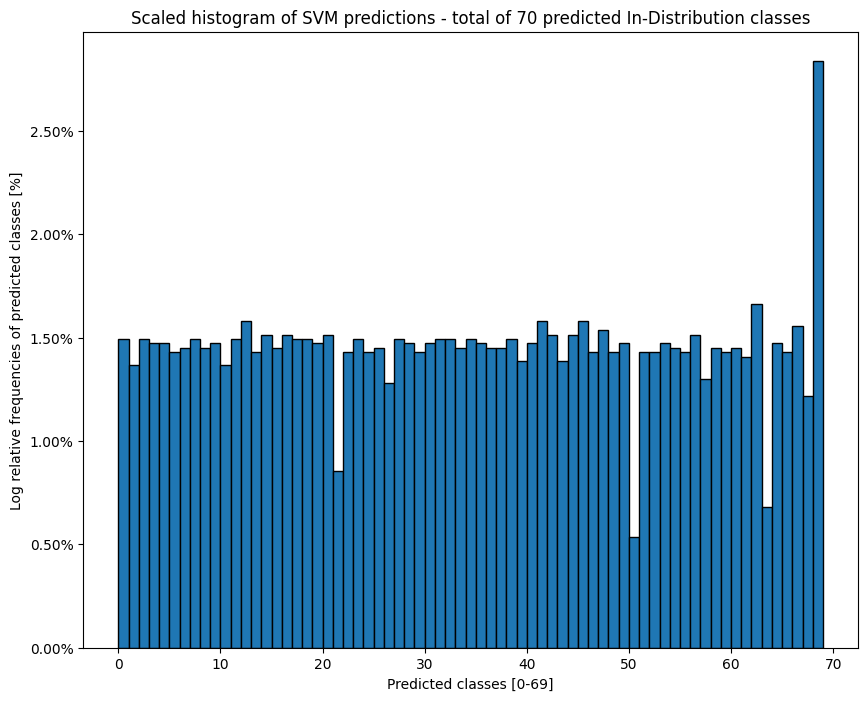

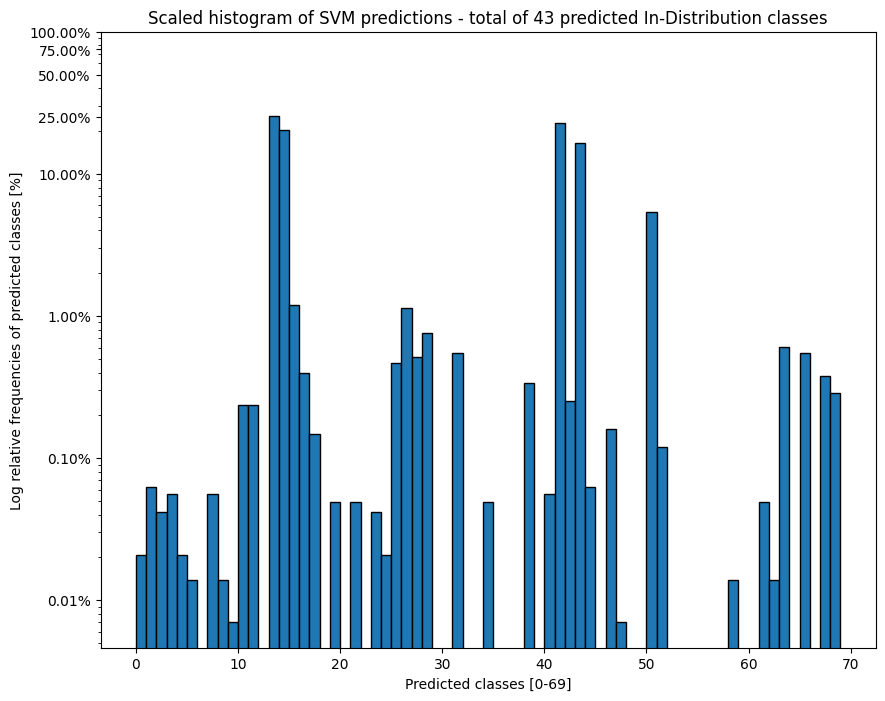

In [5]:
plot_prediction_hist(predictions, use_logspace=False, use_percentage=True)
plot_prediction_hist(predictions_unknown, use_logspace=True, use_percentage=True)

# Evaluation of a model using default hyper-parameters


##### Metrics: mean average precision, mean average recall
---
* $TP$ = number of true samples in the retrieved(positive) samples
* $P$ = number of retrieved(positive) samples
* $T$ = number of true samples in the dataset
* ${precision}_i = \frac{{TP}_i}{{P}_i}$ for each class i
* ${recall}_i = \frac{{TP}_i}{T_i}$ for each class i
* $precision = \frac{\sum_i{{precision}_i}}{N}$ where N is number of classes
* $recall = \frac{\sum_i{{recall}_i}}{N}$ where N is number of classes

In [165]:
linear_svm_pred = linear_svm.predict(X_test)
accuracy = accuracy_score(y_test, linear_svm_pred)
precisions = precision_score(y_test, linear_svm_pred, average=None)
recalls = recall_score(y_test, linear_svm_pred, average=None)
print(f"Accuracy: {accuracy:.4f}, Average Precision: {precisions.mean():.4f}, Average Recall: {recalls.mean():.4f}")

Accuracy: 0.9588, Average Precision: 0.9603, Average Recall: 0.9587


### Predictions analysis 
* 5 compound has precision or recall less than 90%


In [171]:
for compound in np.unique(y)[recalls < 0.9]:
    idx = np.where(y == compound)[0]
    print(f"{compound}: {len(idx)}")
print(f"All compounds count:\n{np.unique(y, return_counts=True)[1]}")

42: 349
43: 347
58: 348
59: 346
62: 346
63: 172
All compounds count:
[343 334 348 341 347 347 348 338 348 349 349 348 349 343 347 343 345 348
 349 349 349 208 344 338 346 345 301 348 348 334 348 348 349 337 348 348
 346 344 348 347 344 347 349 347 339 349 322 349 348 349 127 333 340 345
 343 346 340 301 348 346 335 345 346 172 349 342 349 284 324 335]


# Fine-tuning hyperparameters

### GridSearchCV with cross-validation

In [172]:
# Load test dataset and predict labels
data_root_path = "../data"
ood_dataset_name = "M29_9_system2"
gcxgc = np.load(f"{data_root_path}/ood/{ood_dataset_name}/{ood_dataset_name}.npy").astype('float32')
gcxgc_normalized = np.sum(gcxgc, axis=0)
eps = 0
mask_valid_measurements = (gcxgc_normalized > eps)
X_unknown = gcxgc[:, mask_valid_measurements].transpose(1, 0)
print("[INFO] Testing dataset loaded.")

[INFO] Testing dataset loaded.


In [175]:
import random

data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

cores = multiprocessing.cpu_count()
kernel = 'linear'
seed = 1
norm = 'max'
start = time.time()
if norm == 'l2':
    from sklearn.preprocessing import Normalizer
    normalizer = Normalizer(norm='l2')
    X = normalizer.fit_transform(X)
    X_unknown = normalizer.fit_transform(X_unknown)
elif norm == 'max':
    from sklearn.preprocessing import Normalizer
    normalizer = Normalizer(norm='max')
    X = normalizer.fit_transform(X)
    X_unknown = normalizer.fit_transform(X_unknown)
elif norm == 'sum_to_1':
    X = X / X.sum(1, keepdims=True)
    X_unknown = X_unknown / X_unknown.sum(1, keepdims=True)
print(f"Data normalized in {(time.time() - start):.1f} seconds.")

start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
print(f"Data splitted in {(time.time() - start):.1f} seconds.")

from utils import subsample
start = time.time()
data = {}
data['data_points'] = X_unknown
data['data_labels'] = np.zeros_like(X_unknown)
subsample(data, alpha=0.02, shuffle=True)

noise_percentages = list([0.05, 0.1])
noise_counts = list([1])
noise_ranges = list([(0.3, 1.0),(0.3, 10.0),(0.3, 100.0)])
C = 1e3

best_params = []
params = {(cnt, np, nr) for cnt in noise_counts for np in noise_percentages for nr in noise_ranges}
best_model = None
best_score = 0
for (noise_count, noise_percentage, noise_range) in params:
    print(f"Parameters: noise_count: {noise_count}, noise percentage: {noise_percentage}, noise range: {noise_range}")
    # add noise to data
    X_train_ = add_noise_to_data(X_train, y_train, normalizer, seed, 
                                 noise_percentage=noise_percentage, noise_count=noise_count, noise_range=noise_range)

    start = time.time()
    clf = SVC(kernel=kernel, 
                 decision_function_shape='ovr',
                 probability=False,
                 C=C,
                 shrinking=True,
                 class_weight='balanced',  # class imbalances by class weights
                 break_ties=True,          # break ties according to the confidence values of decision_function
                 random_state=seed,
                 verbose=0)
        
    clf.fit(X_train_, y_train)
    print(f"GridSearch SVM trained in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")
    print(f"Total number of support vectors: {clf.support_.size}")
    print(f"Total number of samples: {X_train_.shape[0]}")
    
    # Evaluate on test split of ID dataset
    start = time.time()
    predictions = clf.predict(X_test)
    pred = predictions                                 
    accuracy = accuracy_score(y_test, linear_svm_pred)
    precisions = precision_score(y_test, linear_svm_pred, average=None)
    recalls = recall_score(y_test, linear_svm_pred, average=None)
    print(f"{np.unique(pred).size} predicted ID classes")
    print(f"Predicted on test split in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")
    print(f"Accuracy: {accuracy:.4f}, Average Precision: {precisions.mean():.4f}, Average Recall: {recalls.mean():.4f}")

    # Evaluate on subset of testing (unknown) dataset
    predictions_unknown = clf.predict(data['data_points'])
    print(f"Predicted on unknown dataset in {(time.time() - start):.1f} seconds ({(time.time() - start)/60:.1f} minutes) using {cores} cores.")
    print(f"{np.unique(predictions_unknown).size} predicted ID classes")
    print("=========")
    
    if np.unique(predictions_unknown).size > best_score:
        best_score = np.unique(predictions_unknown).size
        best_params = [noise_count, noise_percentage, noise_range]
        best_model = clf

print(f"Best score: {best_score}")
print(f"{best_params}")

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 9.4 seconds.
[INFO] Input data shapes: X[(23430, 801)], y[(23430,)]
Data normalized in 26.2 seconds.
Data splitted in 0.5 seconds.
Parameters: noise_count: 1, noise percentage: 0.1, noise range: (0.3, 100.0)
26 samples per class
GridSearch SVM trained in 25.8 seconds (0.4 minutes) using 8 cores.
Total number of support vectors: 5342
Total number of samples: 18744
70 predicted ID classes
Predicted on test split in 9.0 seconds (0.2 minutes) using 8 cores.
Accuracy: 0.9588, Average Precision: 0.9603, Average Recall: 0.9587
Predicted on unknown dataset in 41.4 seconds (0.7 minutes) using 8 cores.
39 predicted ID classes
Parameters: noise_count: 1, noise percentage: 0.05, noise range: (0.3, 10.0)
13 samples per class
GridSearch SVM trained in 12.2 seconds (0.2 minutes) using 8 cores.
Total number of support vectors: 4538
Total number of samples: 18744
70 predicted ID classes
Predicted on test split i

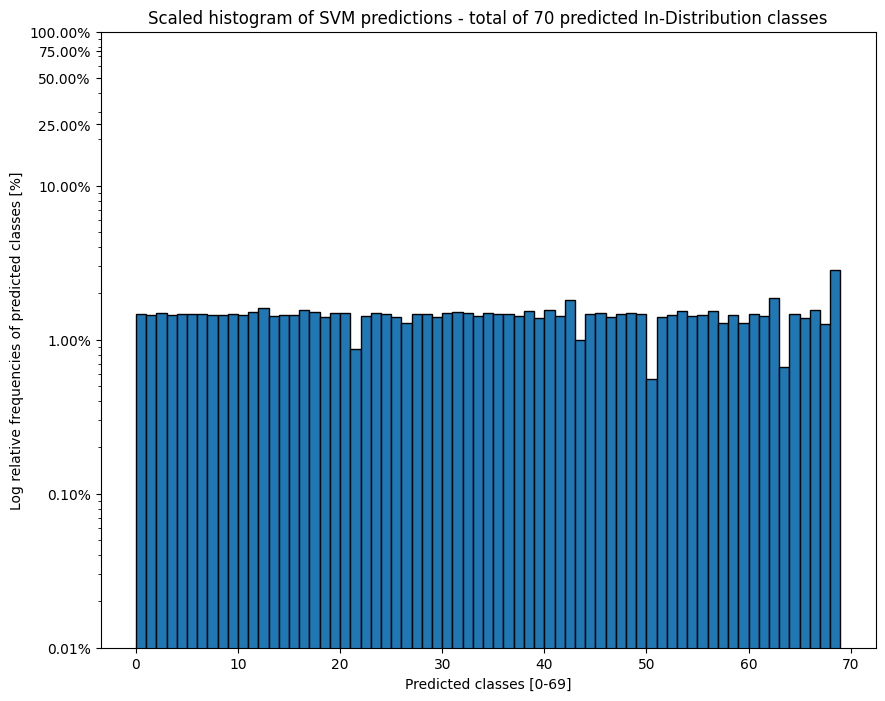

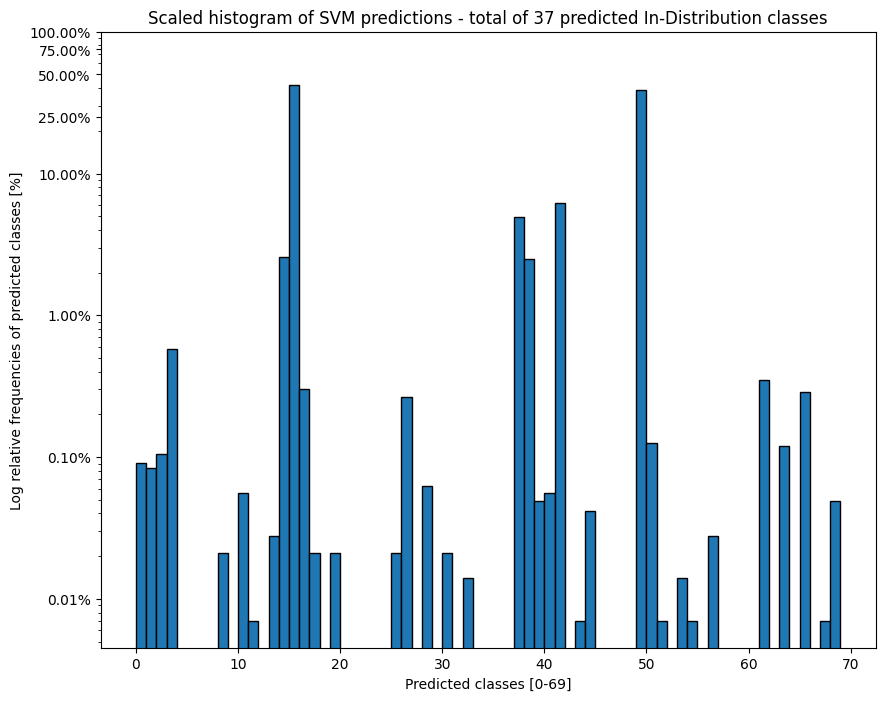

In [177]:
plot_prediction_hist(predictions, True, True)
plot_prediction_hist(predictions_unknown, True, True)

# 5-fold Cross-Validation

In [179]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

# Load dataset
seed = 42
data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

# apply normalization
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='max')
X = normalizer.fit_transform(X)

# run 5-fold cross-validation
k = 5
startTime = time.time()

results = {}
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
with tqdm(kfold.split(X, y), unit="fold") as k_fold:
    for fold, (train_ids, test_ids) in enumerate(k_fold):
        k_fold.set_description(f"Fold {fold+1}")
        X_train = X[train_ids]
        y_train = y[train_ids]
        X_test = X[test_ids]
        y_test = y[test_ids]
        model = SVC(kernel='linear', 
                 decision_function_shape='ovr',
                 probability=True,
                 C=1000,
                 shrinking=True,
                 class_weight='balanced',  # class imbalances by class weights
                 break_ties=True,          # break ties according to the confidence values of decision_function
                 random_state=seed,
                 verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precisions = precision_score(y_test, y_pred, average=None)
        recalls = recall_score(y_test, y_pred, average=None)
        precision = precisions.mean()
        recall = recalls.mean()
        results[fold] = {"accuracy": accuracy,
                         "precision": precision,
                         "recall": recall}
        k_fold.set_postfix(accuracy=100. * accuracy, precision=100. * precision, recall=100. * recall)
print("================================================")
print(f"[INFO] total time taken to evaluate the model: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")  

print(f"Results for 5-fold Cross-Validation:")
test_accuracies = np.array([value["accuracy"] for value in results.values()])
test_precisions = np.array([value["precision"] for value in results.values()])
test_recalls = np.array([value["recall"] for value in results.values()])

print("====================================================================")
print(f"Average accuracy across 5-folder: {100. * test_accuracies.mean():.2f}% (std {100 * test_accuracies.std():.2f})")
print(f"Average precision across 5-folder: {100. * test_precisions.mean():.2f}% (std {100 * test_precisions.std():.2f})")
print(f"Average recall across 5-folder: {100. * test_recalls.mean():.2f}% (std {100 * test_recalls.std():.2f})")
print("====================================================================")
for i, value in enumerate(results.values()):
    print(f"Fold {i} - Accuracy: {value['accuracy']:.3f}, Precision: {value['precision']:.3f}, Recall: {value['recall']:.3f}")

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 9.7 seconds.
[INFO] Input data shapes: X[(23430, 801)], y[(23430,)]


Fold 5: : 5fold [03:48, 45.70s/fold, accuracy=95.2, precision=95.3, recall=95.3]

[INFO] total time taken to evaluate the model: 228.52s or 3.81min.
Results for 5-fold Cross-Validation:
Average accuracy across 5-folder: 95.71% (std 0.26)
Average precision across 5-folder: 95.81% (std 0.28)
Average recall across 5-folder: 95.72% (std 0.24)
Fold 0 - Accuracy: 0.959, Precision: 0.961, Recall: 0.959
Fold 1 - Accuracy: 0.956, Precision: 0.957, Recall: 0.956
Fold 2 - Accuracy: 0.958, Precision: 0.959, Recall: 0.958
Fold 3 - Accuracy: 0.959, Precision: 0.960, Recall: 0.959
Fold 4 - Accuracy: 0.952, Precision: 0.953, Recall: 0.953
